In [1]:
# from qiskit import *
from qiskit.primitives import Estimator

from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.quantum_info.operators import Pauli
from qiskit.quantum_info import Operator
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.hamiltonians.lattices.lattice import Lattice
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

import numpy as np
from functools import *
import scipy.linalg as LA

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session

In [ ]:
nodes = 6
edges = [(0,1, -1),(0,2, -1),(0,3, -1),(0,4, -1),
         (5,1, -1),(5,2, -1),(5,3, -1),(5,4, -1),
         (1,2, -1),(2,3, -1),(3,4, -1),(4,1, -1)]
a
octahedron = Lattice.from_nodes_and_edges(nodes, edges)
fermi_hubb = FermiHubbardModel(octahedron, 1)
hamiltonian = JordanWignerMapper().map(fermi_hubb.second_q_op())
octahedron.to_adjacency_matrix()

array([[0., 1., 1., 1., 1., 0.],
       [1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 0., 1.],
       [0., 1., 1., 1., 1., 0.]])

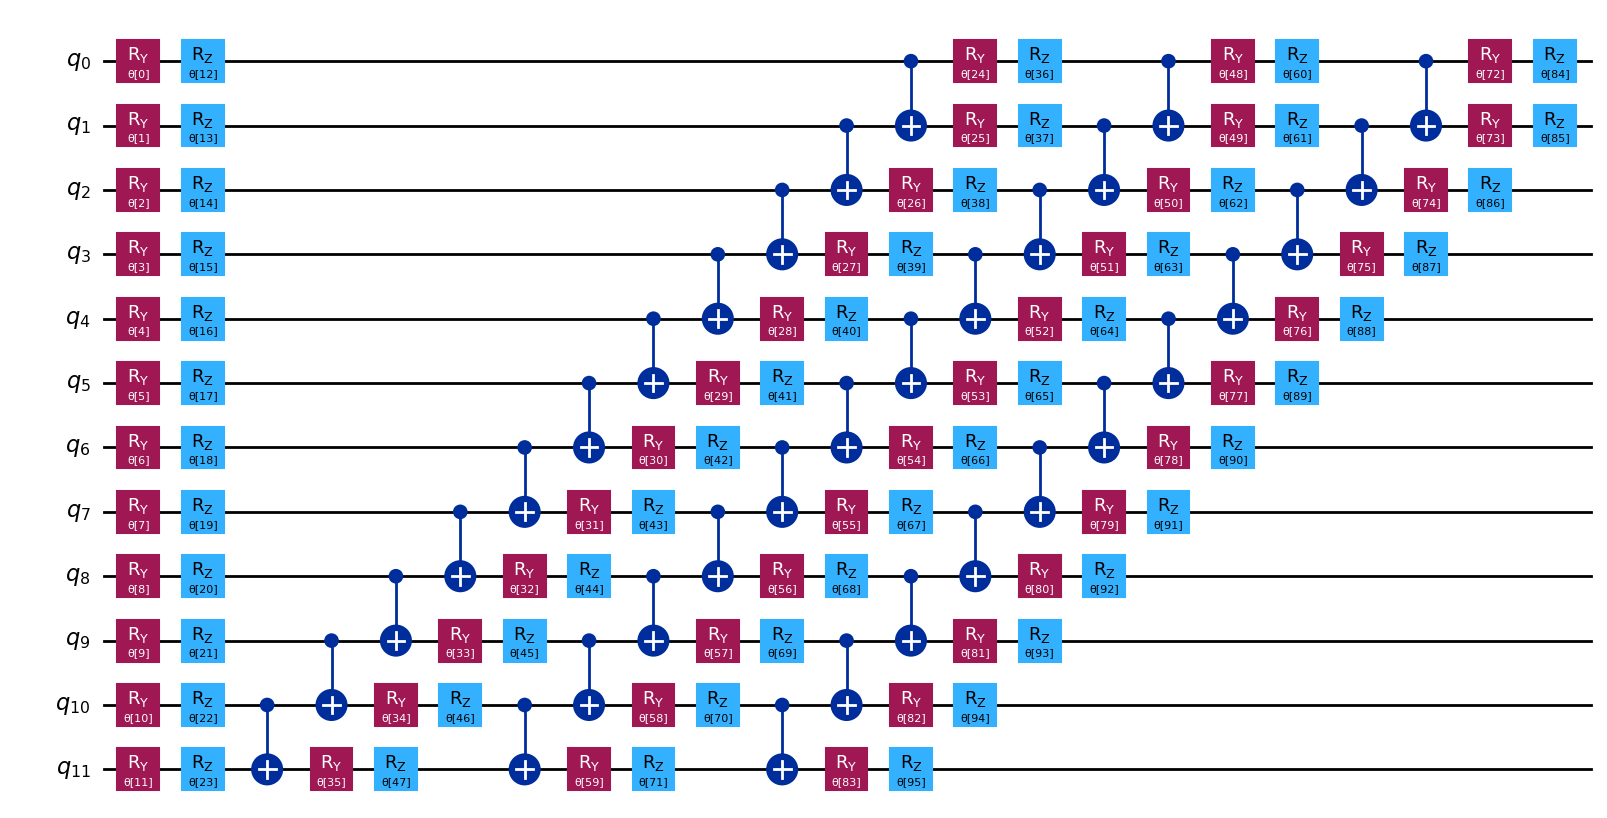

In [4]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [ ]:
num_params = ansatz.num_parameters
num_params


96

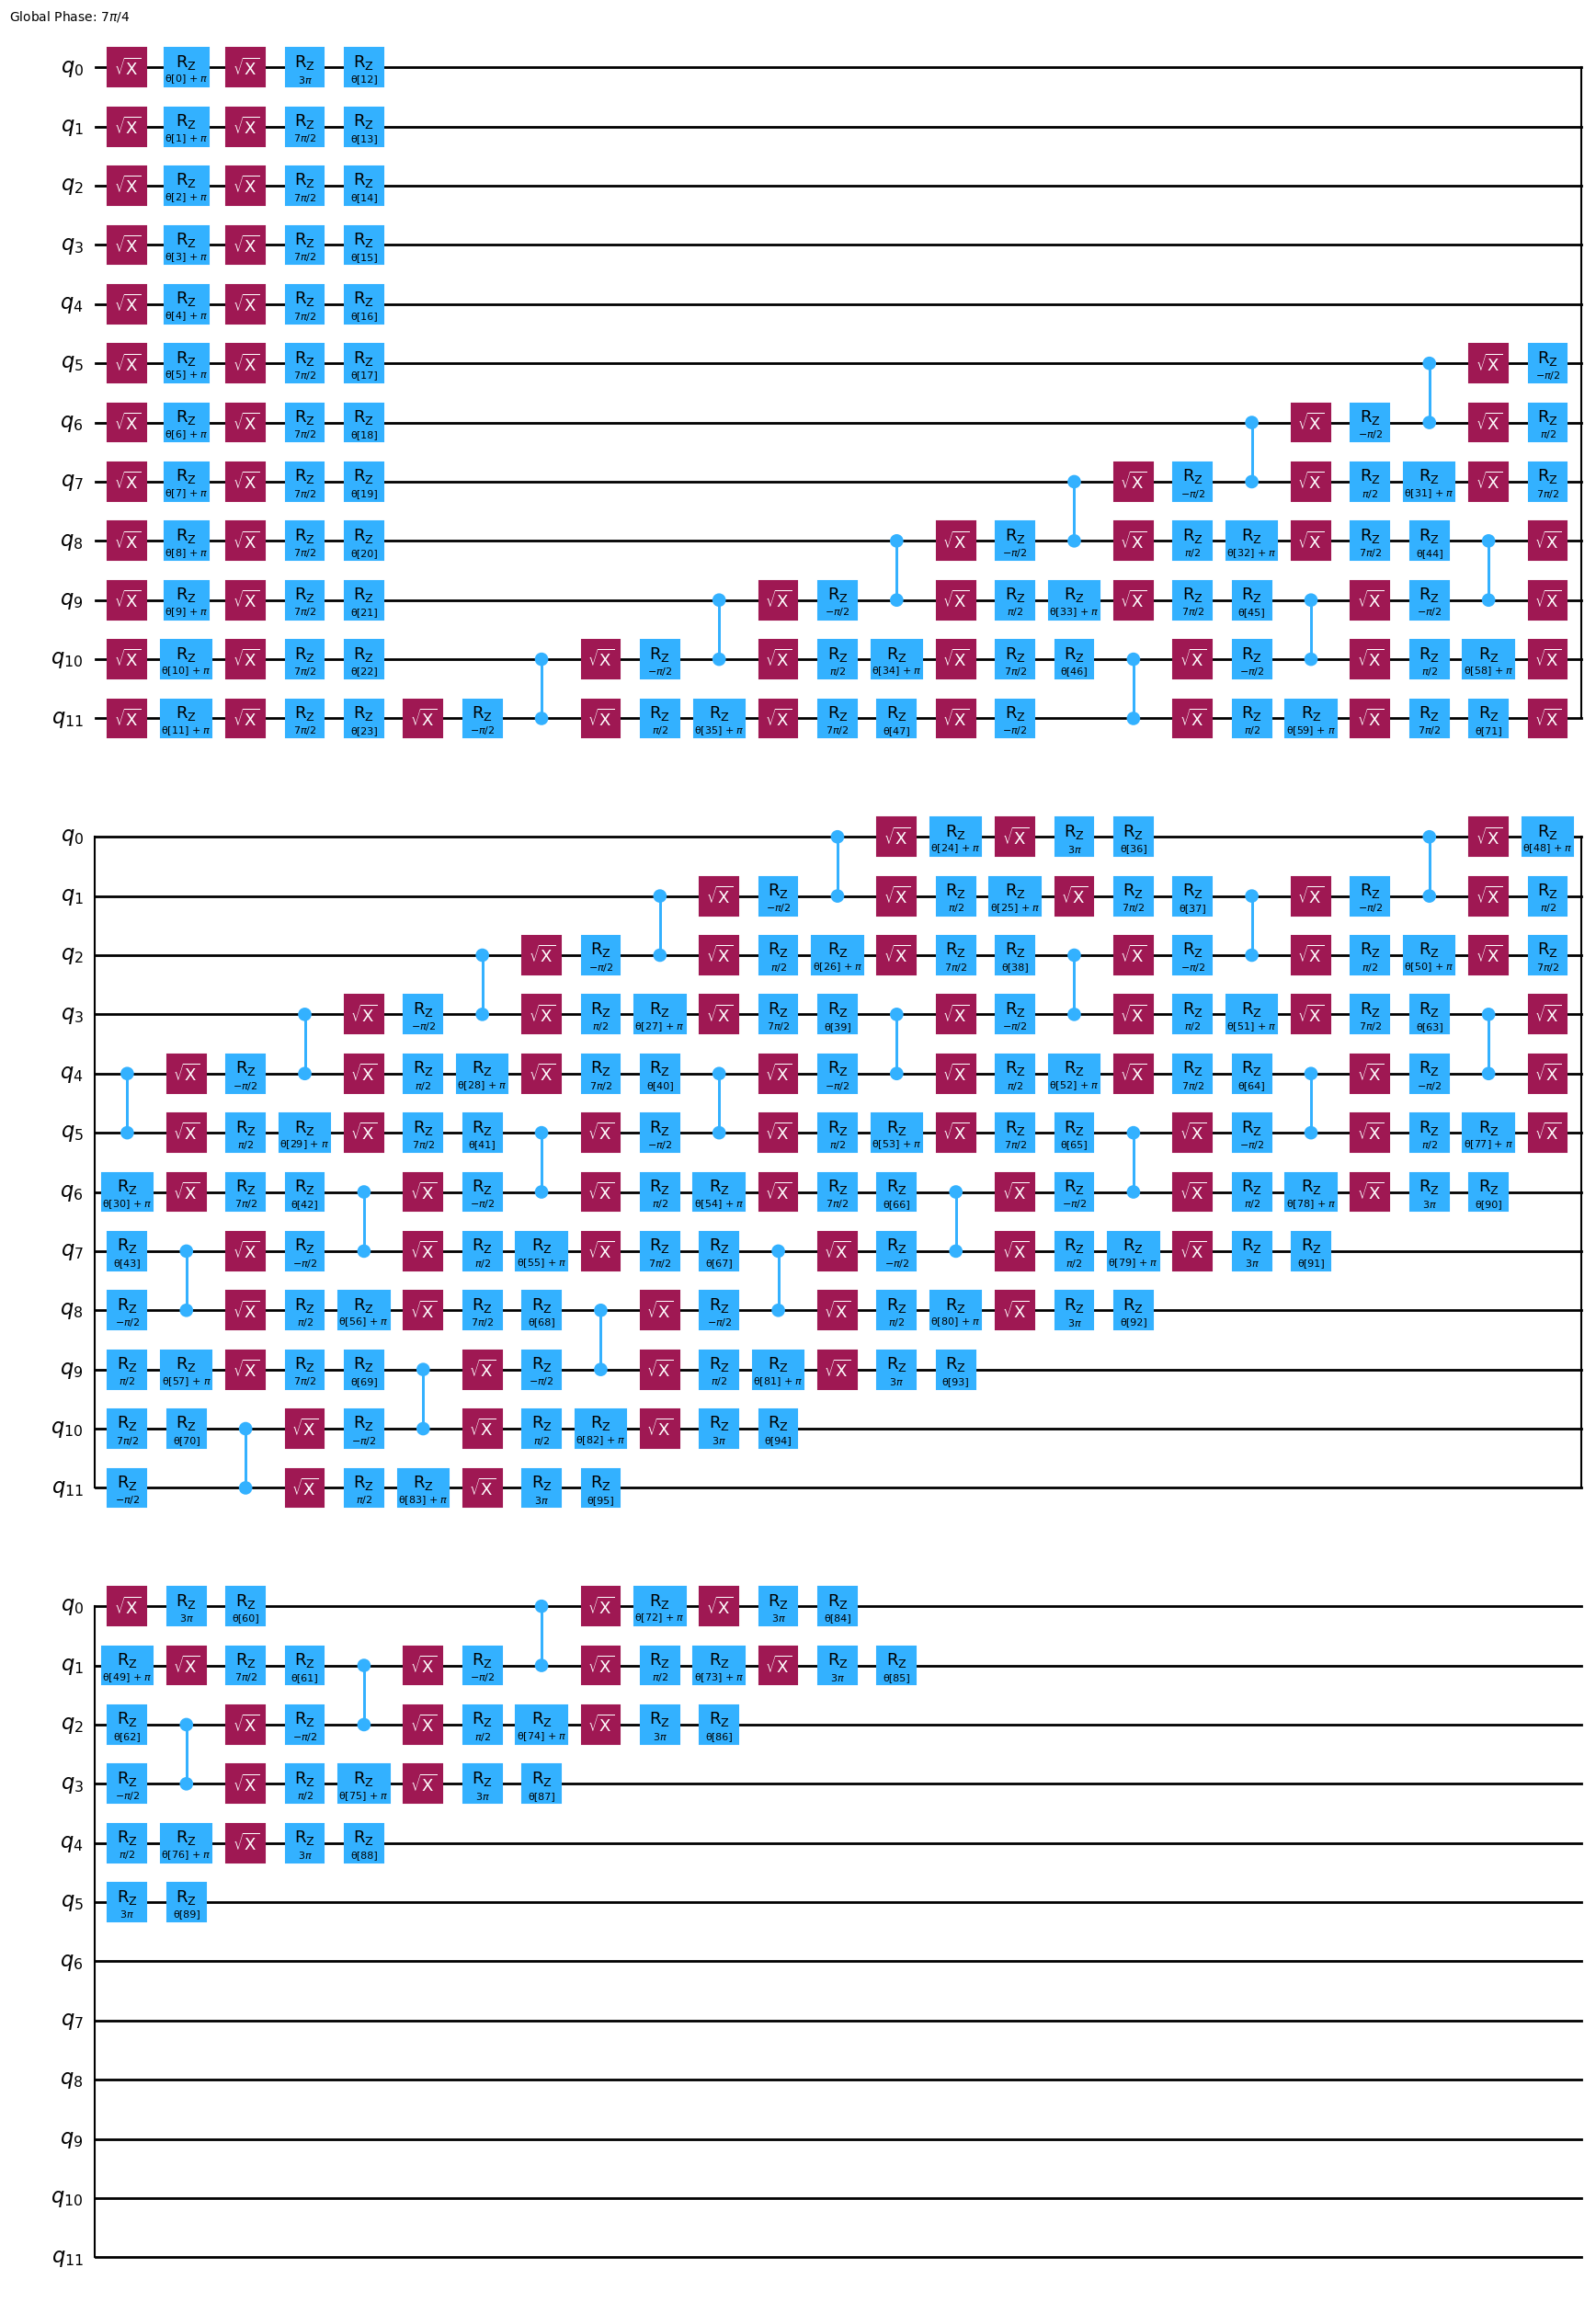

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(basis_gates=["sx", "cz", "rz"], optimization_level=3)

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [28]:
estimator = Estimator()
estimator.options.default_shots = 10000

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

x0 = 2 * np.pi * np.random.random(num_params)

res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
)

ValueError: A backend or session must be specified.